# Long-sequence gate set tomography with ion-trap qubit data

In this notebook, we will use OQT to perform long-sequence gate set tomography using actual experimental data from Sandia's ion trap qubits. The original experiments were done in:

Blume-Kohout, R. et al. Demonstration of qubit operations below a rigorous fault tolerance threshold with gate set tomography. Nat. Commun. 8, 14485 doi: 10.1038/ncomms14485 (2017).

The specific file, `2015_03_30-GST_BB1_XYXY_8192_condensed.txt`, from which experimental data is read, is from the supplementary information of the [original paper](https://www.nature.com/articles/ncomms14485), and can be downloaded [here](https://zenodo.org/record/231329). After downloading the file, it should be stored at the relative path `../data/lsgst/2015_03_30-GST_BB1_XYXY_8192_condensed.txt`

The set of gates in question is $\{G_i, G_x, G_y\}$, where $G_i$ is the identity, $G_x$ is a $\frac{\pi}{2}$ rotation about $x$, and $G_y$ is a $\frac{\pi}{2}$ rotation about $y$.

The original work chooses the set of fiducials: $\{(\cdot), (G_x), (G_y), (G_x, G_x), (G_x, G_x, G_x), (G_y, G_y, G_y) \}$.
We will use only the first 4 $\{(\cdot), (G_x), (G_y), (G_x, G_x)\}$, as using all 6 leads to an $\tilde{F}$ with only rank 4.

In [1]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np
np.set_printoptions(suppress = True, precision = 6)

import qinfer as qi

import datetime

from tqdm import tqdm

import oqt
from oqt.gates import GSeq
from oqt.distributions import ConstantStateDistribution, ConstantSuperoperatorDistribution, CombinedSPAMDistribution
from oqt.errors import GinibreNoise, DepolarizingChannel

%matplotlib inline
%config InlineBackend.print_figure_kwargs = {'dpi': 150}
import matplotlib.pyplot as plt
plt.style.use('ggplot')

Construct the gateset parameterization and the model. 

In [2]:
gateset_labels = ['Gi', 'Gx', 'Gy']
fiducial_labels=[[], ['Gx'], ['Gy'], ['Gx', 'Gx']]

param = oqt.linear_parameterization.GatesetParameterization(
    gateset_labels=gateset_labels, 
    fiducial_labels=fiducial_labels
)

model = qi.BinomialModel(oqt.linear_parameterization.GatesetModel(param))

Let's construct the set of true parameters, that we can use to compare with the experimental data as well as the model parameters we will reconstruct after OQT. 

In [3]:
# Perfect SPAM
vec_ρ = np.array([1, 0, 0, 1]) / np.sqrt(2) # preparing |0><0|
vec_E = np.array([1, 0, 0, 1]) / np.sqrt(2) # measuring |0><0|
ideal_spam = np.einsum("i,j->ij", vec_ρ, vec_E)

# Construct gate set tensor with perfect versions of all gates
gs_tensor_ideal = np.empty((), param.gs_tensor_dtype)
gs_tensor_ideal['Gx'] = oqt.gates.super_rot_x(np.pi/2)
gs_tensor_ideal['Gy'] = oqt.gates.super_rot_y(-np.pi/2)
gs_tensor_ideal['Gi'] = np.eye(4)
gs_tensor_ideal[str(oqt.gates.WellKnownGates.SPAM)] = ideal_spam

# Perfect model parameters
true_params = param.gs_tensor_to_modelparams(np.array([gs_tensor_ideal]))

## Prior distributions

Construct a prior distribution over possible values of our model parameters. Our priors are constructed first by choosing gauge-dependent versions of the superoperators, and then are converted to the gauge independent model parameters.

As we are working with real experimental data, we make our assumptions about the noise more general than simply adding an over or under rotation. Rather, we applying noise to each gate $G_i$, $G_x$, $G_y$ by taking a convex combination of the superoperators with other superoperators pulled randomly from the Ginibre distribution (for channels, this is the BCSZ distribution of superoperators, and we use the qutip function [`rand_super_bcsz`](http://qutip.org/docs/4.0.2/apidoc/functions.html?highlight=rand_dm_ginibre#qutip.random_objects.rand_super_bcsz)):

\begin{equation}
 G \mapsto (1 - \epsilon) \cdot G + \epsilon \cdot \Lambda, \quad \Lambda \in \hbox{BCSZ distribution}
\end{equation} 
The value of $\epsilon$ is some small parameter (e.g. $10^{-4}$) that indicates the strength of the noise. Essentially, we can think of this as a mixture where the true channel is applied a fraction $1 - \epsilon$ of the time, and the remaining $\epsilon$ we have done something completely random.

For the state and measurement, we will apply similar noise, sending

\begin{eqnarray}
 \rho \mapsto (1 - \epsilon) \cdot \rho + \epsilon \sigma_\rho \\\
 E \mapsto (1 - \epsilon) \cdot E + \epsilon \sigma_E
\end{eqnarray}
where $\sigma_\rho$ and $\sigma_E$ are randomly chosen from the Ginibre distribution of density matrices (we use the qutip function [`rand_dm_ginibre`](http://qutip.org/docs/4.0.2/apidoc/functions.html?highlight=rand_dm_ginibre#qutip.random_objects.rand_dm_ginibre), and make transformations to ensure the dimensions and the gauge are correct.)
Following the application of noise to $\rho$ and $E$ individually, we then apply additional, non-trace preserving Ginibre noise to the combined SPAM superoperator. This is done using intuition gained from observing the gauge-fixed superoperators that were reconstructed from the original long-sequence GST work.

In [4]:
# These particular ϵ were chosen after performing a grid search to find
# values that give lowest total variation distance to experimental data
gate_ginib_eps = 1e-4
state_ginib_eps = 1e-4

ρ_distribution = ConstantStateDistribution(vec_ρ, 
                                           channel_error=GinibreNoise(eps=state_ginib_eps))

E_distribution = ConstantStateDistribution(vec_E, 
                                           channel_error=GinibreNoise(eps=state_ginib_eps))

unknown_operators = {'Gi' : ConstantSuperoperatorDistribution(
                                                 np.eye(4), 
                                                 channel_error=[GinibreNoise(eps=gate_ginib_eps)]
                            ),
                     
                     'Gx' : ConstantSuperoperatorDistribution(
                                                 oqt.gates.super_rot_x(np.pi/2),
                                                 channel_error=[GinibreNoise(eps=gate_ginib_eps)]
                            ),
                                         
                     'Gy' : ConstantSuperoperatorDistribution(
                                                 oqt.gates.super_rot_y(-np.pi/2),
                                                 channel_error=[GinibreNoise(eps=gate_ginib_eps)]
                            ),
                                          
                     'WellKnownGates.SPAM' : CombinedSPAMDistribution(
                                                 state=ρ_distribution, 
                                                 measurement=E_distribution)
                    }

prior = oqt.distributions.GSTProductDistribution(param, unknown_operators=unknown_operators)

In [5]:
prior.sample()

array([[0.999907, 0.499971, 0.500024, 0.000208, 0.49998 , 0.500034,
        0.499955, 0.000221, 0.499967, 0.499962, 0.999715, 0.999828,
        0.49996 , 0.499992, 0.000256, 0.499954, 0.00025 , 0.499971,
        0.500056, 0.500009, 0.499967, 0.00027 , 0.499988, 0.000286,
        0.500045, 0.499995, 0.999667, 0.000277, 0.500034, 0.500006,
        0.499997, 0.00026 , 0.500016, 0.500027, 0.50001 , 0.499969,
        0.999708, 0.500051, 0.999702, 0.500084]])

## Gather experimental data

Rather than using a heuristic to generate the sequences, we're going to read in the sequences, as well as experimental data, directly from the Sandia group's supplementary material. This next code fragment does all this based on the structure of the file, and then parses it using regex (thanks Gary!) into sequences and count data.

In [6]:
import re
import subprocess

# Here we're going to gather all the experimental data from the file
filename = "../data/lsgst/2015_03_30-GST_BB1_XYXY_8192_condensed.txt"

# Get the total number of experiments; one per line, I've deleted the header from the original
num_experiments = int(subprocess.check_output(["wc", "-l", filename]).split()[0])
max_experiments = num_experiments

# Store experiments as experiment object and outcomes as outcomes
experiments = []
outcomes = []

# Now pull the data; we pull the first 3 columns, the sequence, and the counts/total counts
# The sequence is the trickiest as we will have to parse it and turn it into a GSeq object

# The regex groups into 3 sections - some sequence of GxGy..., then a (germ)^exp, then another GxGi...
# We'll parse them separately afterwards (assuming all gate identifiers are 2 chars long),
# to build up the actual sequence
pattern = r"(\w*)(\((.*)\)\^\d+)?(.*)?"

with open(filename) as infile:
    for exp_idx, line in enumerate(infile):
        if exp_idx > max_experiments: 
            break 
            
        read_exp_data = line.split()[0:3] # past tense of read!
        current_seq = read_exp_data[0]
        recorded_counts, total_shots = int(float(read_exp_data[1])), int(read_exp_data[2])
        
        # Parse the sequence... group by the patterns then tokenize
        # indices 1, 2, 4 are based on the structure of the regex
        grouped = re.match(pattern, current_seq)
        tokens = list(filter(None, [grouped.group(1), grouped.group(2), grouped.group(4)]))
        
        new_experiment = np.empty((1,), dtype=model.expparams_dtype)
        
        gate_sequence = GSeq()
                
        if exp_idx > 0:
            for token in tokens:
                # Get the alphabetical sequence of gates from this token
                alpha_gate_list = re.findall("[a-zA-Z]+", token)[0] 
                alpha_gate_seq = [alpha_gate_list[i:i+2] for i in range(0, len(alpha_gate_list), 2)]
    
                if "(" in token: # Case where there is a paren and then an exponent
                    exponent = int(re.findall("[0-9]+", token)[0])
                    if len(alpha_gate_seq) == 1:
                        gate_sequence += GSeq((alpha_gate_seq[0], exponent))
                    else: # Make a GSeq inside a GSeq so matrix multiplication works (FAST) from inside out
                        gate_sequence += GSeq((GSeq(*alpha_gate_seq), exponent))
                else:
                    gate_sequence += GSeq(alpha_gate_seq)
            
        new_experiment[0]['sequence'] = gate_sequence
        new_experiment[0]['n_meas'] = total_shots
        new_outcomes =  recorded_counts
        
        experiments.append(new_experiment)
        outcomes.append(new_outcomes)
        
full_experiments = experiments
full_outcomes = outcomes

In [7]:
len(full_experiments)

4657

### Test experiments

We are going to set aside a number of experiments for the purpose of testing afterwards; these are experiments that specifically have the form ${G^{2^n}}$ for $n = 0,\ldots13$ and $G$ being all possible gates in the set, $G_i, G_x, $ and $G_y$. 

In [8]:
num_test_experiments = 14
gate_powers = [2 ** x for x in range(num_test_experiments)]

test_experiments = []

n_shots = full_experiments[0]['n_meas']

for gate in param.gateset_labels:
    for power in gate_powers:
        gate_sequence = GSeq()
        new_experiment = np.empty((1,), dtype=model.expparams_dtype)
        new_experiment[0]['sequence'] = gate_sequence + GSeq((gate, power))
        new_experiment[0]['n_meas'] = n_shots
        test_experiments.append(new_experiment)

In [9]:
len(test_experiments)

42

## Training

Let's set up the updater and start training! Surprisingly, you can get pretty good results using only 10000 particles.

In [10]:
# Set up the particle and SMC updater
n_particles = 10000
updater = qi.SMCUpdater(model, n_particles, prior)

Now we run the experiments one by one, and perform Bayesian updates. This takes between 10-30 minutes depending on your processor speed. If you don't want to run it, skip this cell, but load the next so you get the file prefixes.

In [20]:
num_experiments = len(full_experiments)

for idx_experiment in tqdm(range(num_experiments)):
    # Skip over any experiments that are also in the testing set
    if full_experiments[idx_experiment] not in test_experiments:
        experiment = full_experiments[idx_experiment]
        datum = 50 - full_outcomes[idx_experiment]

        with qi.perf_testing.numpy_err_policy(invalid='raise'):
            updater.update(datum, experiment)

100%|██████████| 4657/4657 [10:38<00:00,  7.29it/s]


In [22]:
date_prefix = datetime.date.today().isoformat()
fiducial_prefix = f"-{n_particles}p" + "-".join(["".join(x) for x in fiducial_labels]) + "-"
dir_prefix = "../data/lsgst/"

output_prefix = dir_prefix + date_prefix + fiducial_prefix

parameter_prefix = f"gg{gate_ginib_eps}-s{state_ginib_eps}"
output_prefix += parameter_prefix 

# Save the data
np.save(f"{output_prefix}-locs", updater.particle_locations)    
np.save(f"{output_prefix}-wgts", updater.particle_weights)

## Analysis

In [11]:
# Load in the data from files; change names as needed; this file in particular was
# the best output of the grid search
output_prefix = "../data/lsgst/2020-04-12-gridsearch-best"
particle_locations = np.load(f"{output_prefix}-locs.npy")  
particle_weights = np.load(f"{output_prefix}-wgts.npy").reshape((particle_locations.shape[0], 1))

# # Otherwise, use the data from the updater
# particle_locations = updater.particle_locations
# particle_weights = updater.particle_weights.reshape((updater.particle_weights.shape[0], 1))

This is the set of gauge-fixed superoperators that was reconstructed from the same data in the original LSGST paper. It can be found in the supplementary materials in the same location as the experimental outcome data. 

In [12]:
pygsti_best_fit = np.empty((), param.gs_tensor_dtype)

pygsti_best_fit['Gx'] = np.array([[ 1.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
                                  [ 4.20528992e-07,  9.99946258e-01,  5.39449377e-05, -6.46354140e-06],
                                  [ 4.02238460e-06,  1.86119648e-05,  5.10510551e-05, -9.99904465e-01],
                                  [-3.71625636e-07,  4.42074230e-05,  9.99903844e-01,  5.66471749e-05]])

pygsti_best_fit['Gy'] = np.array([[ 1.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
                                  [-2.84461040e-06,  1.72816657e-05,  2.03294042e-05,  9.99875670e-01],
                                  [-4.41163804e-06, -1.60461436e-05,  9.99962425e-01,  6.49955313e-06],
                                  [ 1.08371997e-06, -9.99875918e-01,  2.51775920e-05, -4.54572651e-05]])

pygsti_best_fit['Gi'] = np.array([[ 1.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
                                  [ 2.10177470e-06,  9.99931872e-01, -6.44198677e-05,  1.01922740e-05],
                                  [ 6.43859878e-06,  2.76865350e-05,  9.99890681e-01,  2.23798528e-05],
                                  [-1.53446482e-06, -2.58386951e-05, -5.68170561e-05,  9.99899616e-01]])

pygsti_rho0 = np.array([[ 0.70710678],
                        [ 0.00242797],
                        [-0.00602108],
                        [ 0.70158617]])

pygsti_E = np.array([[0.7121799 ],
                     [0.00075139],
                     [0.00085205],
                     [0.70162408]]).T 

pygsti_best_fit[str(oqt.gates.WellKnownGates.SPAM)] = pygsti_rho0 * pygsti_E

pygsti_params = param.gs_tensor_to_modelparams(np.array([pygsti_best_fit]))

We need to simulate data for these new experiments and look at the counts we get. We'll use the mean over the posterior as our 'reconstructed gateset'.

Calculate and plot the likelihood instead of counts from a simulated experiment. For the experimental values, we will plot the observed frequencies using the data taken over 50 counts.

In [13]:
Gx_experimental_likelihood = np.array([25, 50, 0, 0, 1, 0, 0, 0, 1, 1, 0, 7, 12, 21]) / 50
Gy_experimental_likelihood = np.array([28, 50, 0, 1, 0, 0, 0, 0, 0, 3, 2, 5, 13, 22]) / 50
Gi_experimental_likelihood = np.array([0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 1, 4, 9, 19]) / 50

In [14]:
# Parameters for test experiments - (gate)^power where the powers are powers of 2
def compute_likelihood_comparison(gate, experimental_likelihood):
    single_gate_test_experiments = []

    n_shots = full_experiments[0]['n_meas']

    for power in gate_powers:
        new_experiment = np.empty((1,), dtype=model.expparams_dtype)
        new_experiment['sequence'] = GSeq((gate, power))
        new_experiment['n_meas'] = n_shots
        single_gate_test_experiments.append(new_experiment)

    oqt_likelihood = np.empty(len(gate_powers))
    true_likelihood = np.empty(len(gate_powers))
    pygsti_likelihood = np.empty(len(gate_powers))
    
    reconstructed_params = np.array([np.sum(particle_weights * particle_locations, axis = 0)])
    
    for idx_experiment, experiment in enumerate(single_gate_test_experiments):
        oqt_likelihood[idx_experiment] = model.underlying_model.likelihood(outcomes, reconstructed_params, experiment)[0, :, 0]
        true_likelihood[idx_experiment] = model.underlying_model.likelihood(outcomes, true_params, experiment)[0, :, 0]
        pygsti_likelihood[idx_experiment] = model.underlying_model.likelihood(outcomes, pygsti_params, experiment)[0, :, 0]

    return oqt_likelihood, true_likelihood, pygsti_likelihood

In [15]:
# For a given gate, make a plot of the likelihoods for the true case, the experiment, the OQT reconstruction, 
# and the pyGSTi reconstruction. This matches plot 1c in the Sandia paper. 
def plot_1c(gate, oqt_likelihood, true_likelihood, pygsti_likelihood, experimental_likelihood, ax=None):      
    if ax is None:
        ax = plt.gca()
    ax.semilogx(gate_powers, oqt_likelihood)
    ax.scatter(gate_powers, oqt_likelihood)
    ax.semilogx(gate_powers, true_likelihood)
    ax.scatter(gate_powers, true_likelihood)
    ax.semilogx(gate_powers, 1 - pygsti_likelihood)
    ax.scatter(gate_powers, 1 - pygsti_likelihood)
    ax.semilogx(gate_powers, experimental_likelihood)
    ax.scatter(gate_powers, experimental_likelihood)
    ax.set_xlabel(f'Number of {gate} button presses')
    ax.set_ylabel('Sequence probability')
    ax.set_ylim([-0.05, 1.05])
    ax.set_title(f'Sequence probability vs. number of {gate} button presses')
    ax.legend(['OQT posterior mean', 'Ideal', 'pyGSTi', 'Experiment'])

In [16]:
# Compute and plot the total variation distance
def tvd(p, q):
    return np.abs(p - q)

def plot_tvd(gate, oqt_tvd, pyg_tvd, ax=None):
    if ax is None:
        ax = plt.gca()
    ax.semilogx(gate_powers, oqt_tvd, color='#E24A33')
    ax.scatter(gate_powers, oqt_tvd, color='#E24A33')
    ax.semilogx(gate_powers, pyg_tvd, color='#988ED5')
    ax.scatter(gate_powers, pyg_tvd, color='#988ED5')
    ax.set_xlabel(f'Number of {gate} button presses')
    ax.set_ylabel('TVD')
    ax.set_ylim([-0.0001, 0.3])
    ax.set_title(f'Distance from experimental data')

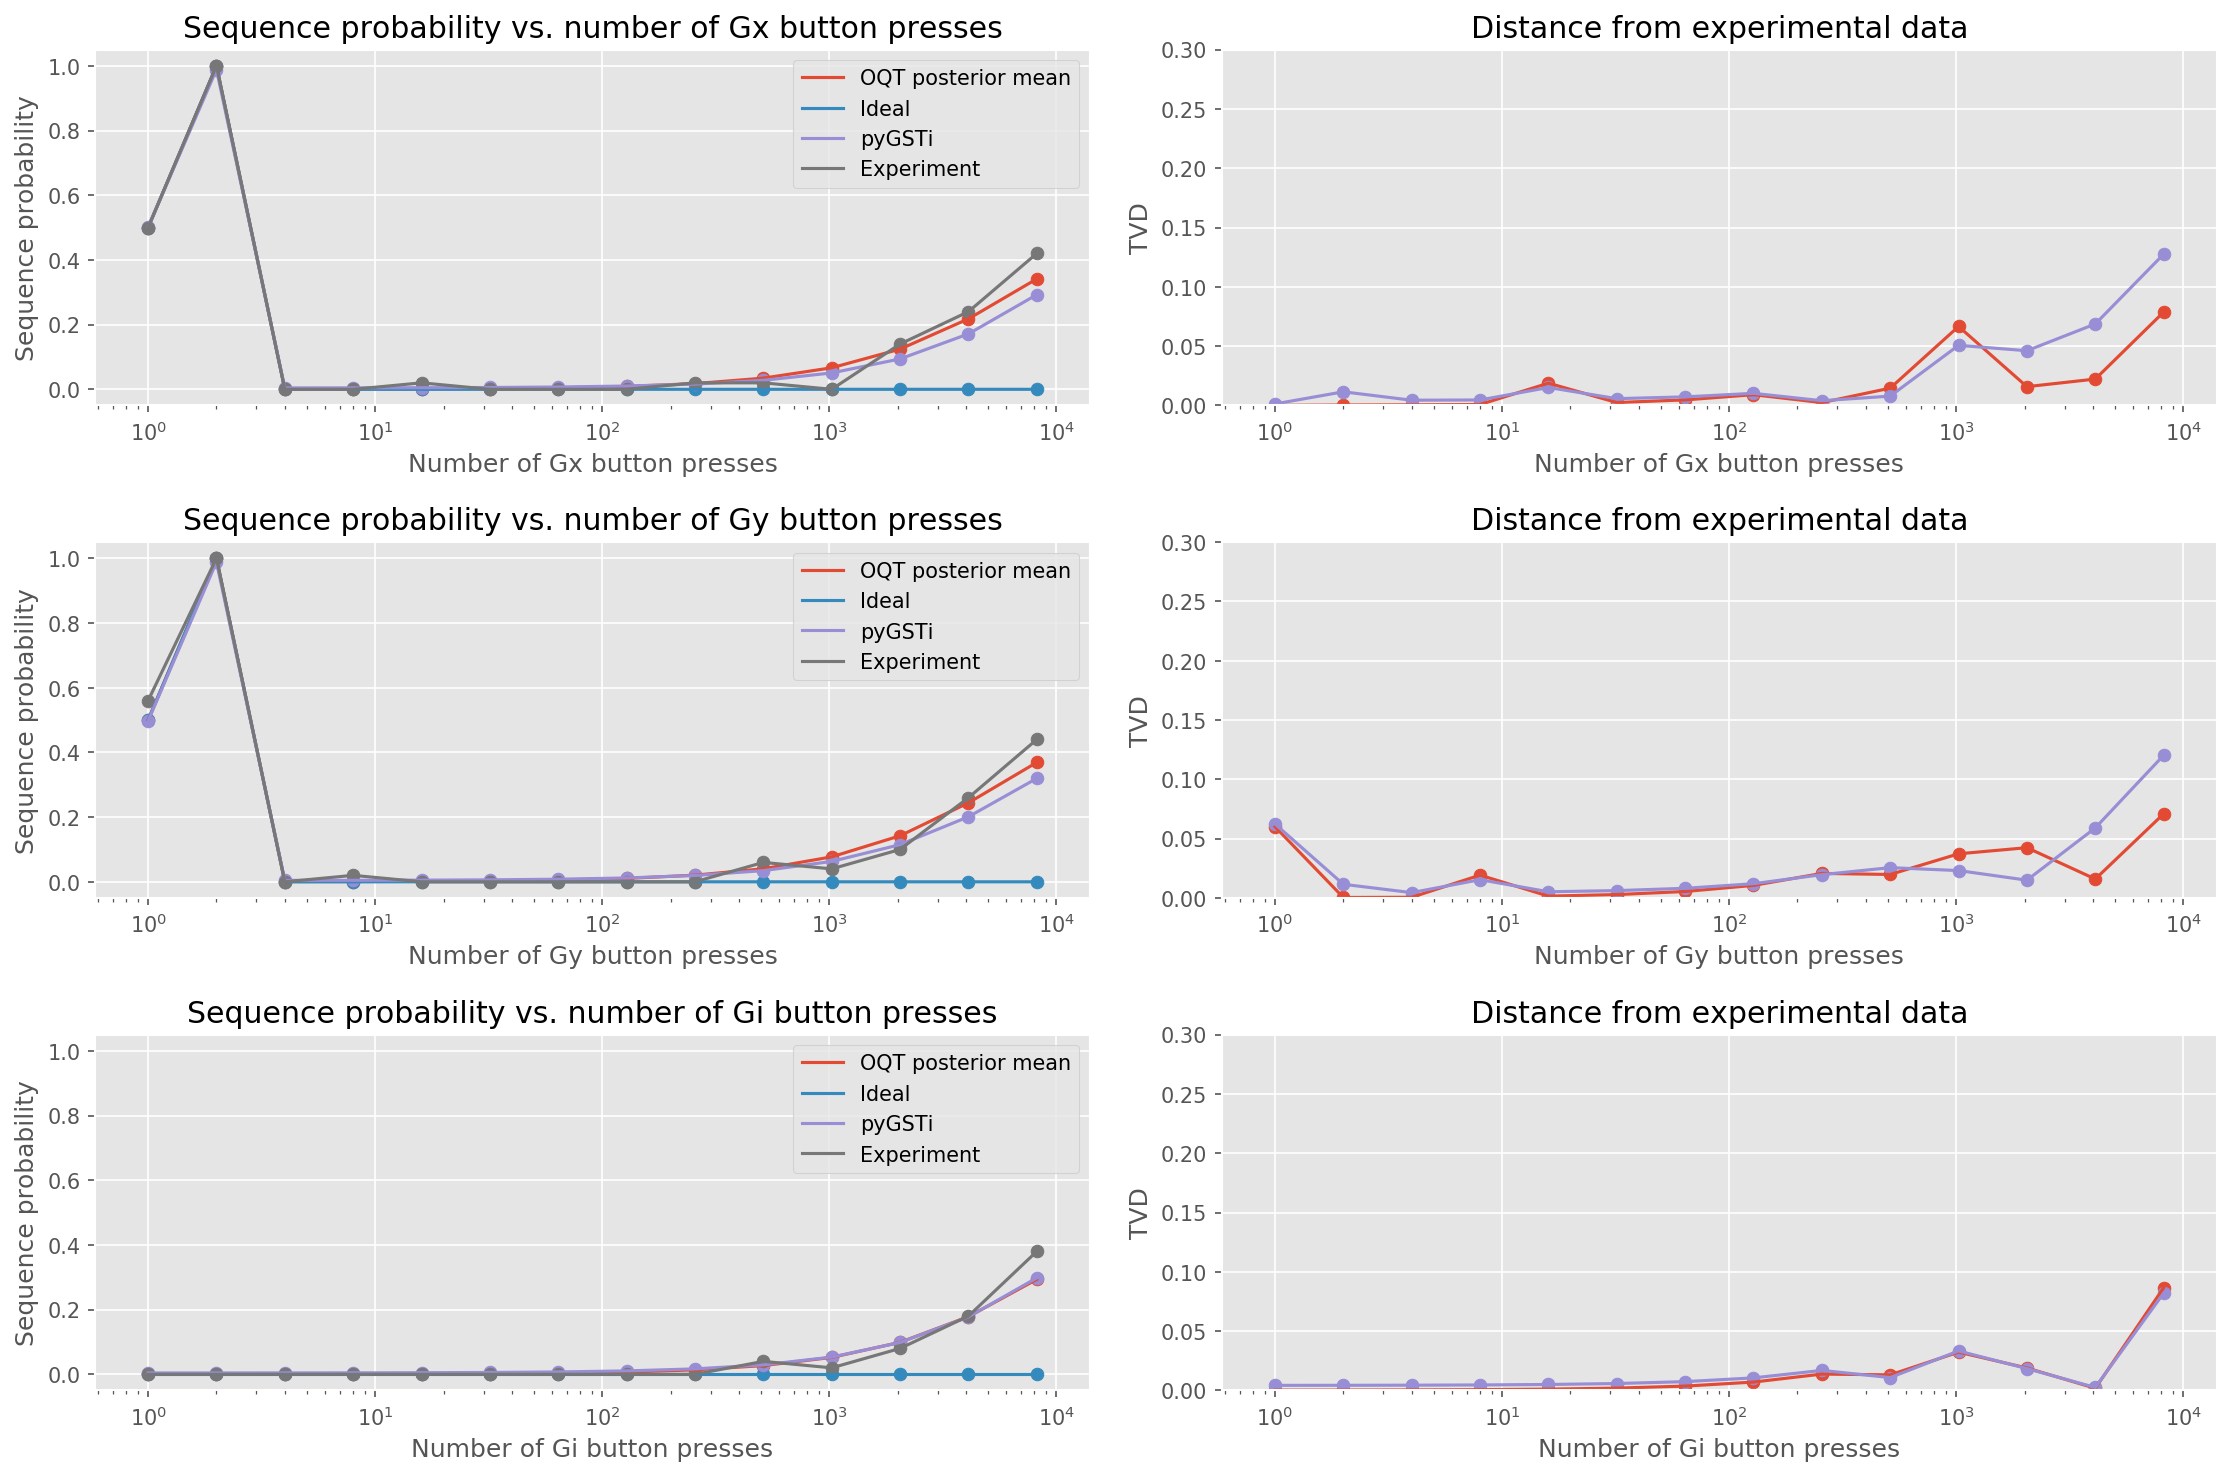

In [17]:
# Plot all data
fig, ax = plt.subplots(3, 2, figsize=(15, 10))

total_oqt_tvd = 0
total_pyg_tvd = 0

gate_data_map = {'Gx' : Gx_experimental_likelihood, 
                 'Gy' : Gy_experimental_likelihood, 
                 'Gi' : Gi_experimental_likelihood}

for gate_idx, (gate, data) in enumerate(gate_data_map.items()):
    oqt_l, true_l, pyg_l = compute_likelihood_comparison(gate, data)
    plot_1c(gate, oqt_l, true_l, 1 - pyg_l, data, ax[gate_idx, 0])
    
    oqt_tvd = tvd(gate_data_map[gate], oqt_l)
    pyg_tvd = tvd(gate_data_map[gate], pyg_l)
    
    total_oqt_tvd += np.sum(oqt_tvd)
    total_pyg_tvd += np.sum(pyg_tvd)
    
    plot_tvd(gate, oqt_tvd, pyg_tvd, ax[gate_idx, 1])
    
plt.tight_layout()
#plt.savefig(f"{output_prefix}_sample_1c_combined.pdf")

In [18]:
print(f"TVD from experimental data for OQT reconstruction: {total_oqt_tvd}")
print(f"TVD from experimental data for pyGSTi reconstruction: {total_pyg_tvd}")

TVD from experimental data for OQT reconstruction: 0.72431880783881
TVD from experimental data for pyGSTi reconstruction: 0.9609660572145853


In [ ]:
# Same plots, but do them separately so we can save them individually
for gate_idx, (gate, data) in enumerate(gate_data_map.items()):
    oqt_l, true_l, pyg_l = compute_likelihood_comparison(gate, data)
    
    plot_1c(gate, oqt_l, true_l, 1 - pyg_l, data)
    plt.savefig(f"{output_prefix}-{gate}-1c.pdf")
    plt.show()
    
    oqt_tvd = tvd(gate_data_map[gate], oqt_l)
    pyg_tvd = tvd(gate_data_map[gate], pyg_l)
    
    plot_tvd(gate, oqt_tvd, pyg_tvd)
    plt.savefig(f"{output_prefix}-{gate}-tvd.pdf")
    plt.show()

## Figure 4 copy

Generate a copy-cat of figure 4 where we compute difference between log-likelihoods.

In [19]:
# First, generate all the experiments that are used. Sandia's figure uses their 6 fiducials 
# with a germ power sandwiched in between.
from itertools import product
from scipy.stats import entropy

all_sequences = [exp['sequence'][0].flatten() for exp in full_experiments]

n_shots = 50
fiducials = [[], ['Gx'], ['Gy'], ['Gx', 'Gx'], ['Gx', 'Gx', 'Gx'], ['Gy', 'Gy', 'Gy']]

# The set of germs and powers used fo
germs = [['Gx', 'Gx', 'Gy', 'Gx', 'Gy', 'Gy'],
         ['Gx', 'Gy', 'Gy', 'Gi'],
         ['Gx', 'Gx', 'Gi', 'Gy'],
         ['Gy', 'Gi', 'Gi'],
         ['Gx', 'Gi', 'Gi'],
         ['Gx', 'Gi', 'Gy'],
         ['Gx', 'Gy', 'Gi'],
         ['Gx', 'Gy'],
         ['Gi'], 
         ['Gy'],
         ['Gx']]

# For each germ, generate the set of powers to be used
germ_powers = []
for germ in germs:    
    germ_powers.append([int(np.floor(2**m / len(germ))) for m in range(11)])

def markovianity_experiments(fiducials, germ, power, n_shots):
    exps = []
    
    for right_fid, left_fid in product(fiducials, repeat=2):
        new_experiment = np.empty((1,), dtype=model.expparams_dtype)
        new_experiment[0]['sequence'] = GSeq(left_fid + germ * power + right_fid)
        new_experiment[0]['n_meas'] = n_shots
        exps.append(new_experiment)

    return exps

In [20]:
# Now, a function to run an experiment to produce an estimate of the frequencies and take the difference with entropy
def delta_log_l(model, reconstructed_params, experiments):
    outcomes = np.array([0], dtype='uint')
    
    n_shots = experiments[0]['n_meas']
    
    # Get probabilites for each experiment
    p_s = np.array([model._underlying_model.likelihood(outcomes, reconstructed_params, experiment)[0, :, 0] for experiment in experiments]).reshape(len(experiments))

    # Now get experimental frequencies
    f_s = np.zeros(len(experiments))
    for idx_experiment, experiment in enumerate(experiments):
        f_s[idx_experiment] = full_outcomes[all_sequences.index(experiment['sequence'][0].flatten())] / n_shots


    comp_entropy = n_shots * np.sum(np.log(pow(f_s, f_s) * pow(1 - f_s, 1 - f_s)))
    l_max = n_shots * np.sum(np.log(pow(p_s, f_s) * pow(1 - p_s, 1 - f_s)))
    return 2 * (comp_entropy - l_max)[0]

In [21]:
reconstructed_params = np.array([np.sum(particle_weights * particle_locations, axis = 0)])

# An array to populate the table
log_likelihood_array = np.zeros((len(germs), 11))

for idx_germ, germ in enumerate(germs): # for each germ
    # These are the powers we will look at for this particular germ.
    # If the list is shorter than max_power, we will pad it with 0s after
    # the fact
    power_list = germ_powers[idx_germ]
    fill_offset = power_list.count(0)
    
    germ_likelihoods = np.zeros(len(germ_powers[idx_germ]))

    for idx_power, power in enumerate(power_list): # look at each non-zero power individually
        # Construct the experiments
        if power == 0:
            continue
        
        experiments = markovianity_experiments(fiducials, germ, power, n_shots)
 
        germ_likelihoods[idx_power] = delta_log_l(model, pygsti_params, experiments) 
      
    log_likelihood_array[idx_germ,:] = germ_likelihoods

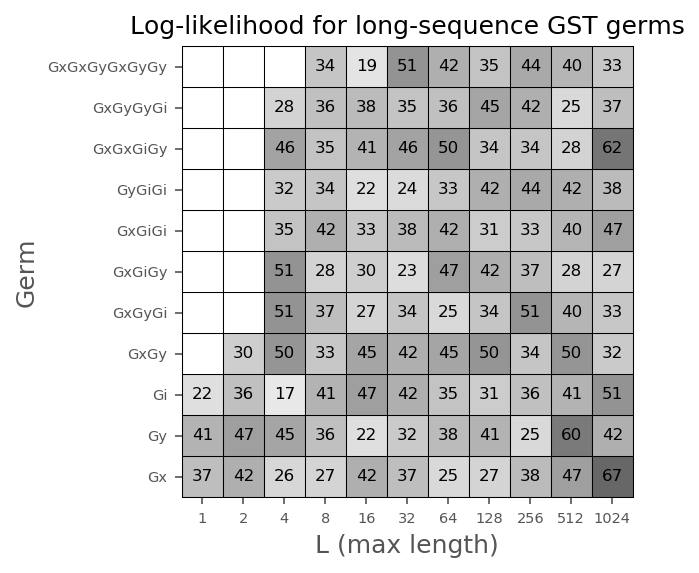

In [22]:
data = np.flipud(np.round(log_likelihood_array))
fig, ax = plt.subplots()

ax.pcolor(data, edgecolors='k', linewidths=0.5, cmap="Greys", snap=True, vmin=0, vmax=100)
plt.xlabel("L (max length)")
plt.xticks([x + 0.5 for x in range(11)])
plt.ylabel("Germ")
plt.yticks([x + 0.5 for x in range(11)])
plt.title("Log-likelihood for long-sequence GST germs", fontsize=12)

[ax.spines[x].set_color('k') for x in ax.spines.keys()]
[ax.spines[x].set_linewidth(0.5) for x in ax.spines.keys()]

ax.set_aspect('equal')
# Use the code from the example to get the text on the grid
# https://matplotlib.org/gallery/images_contours_and_fields/image_annotated_heatmap.html#sphx-glr-gallery-images-contours-and-fields-image-annotated-heatmap-py
for i in range(data.shape[0]):
    for j in range(data.shape[1]):
        if int(data[i, j]) is not 0:
            text = ax.text(j + 0.5, i + 0.5, int(data[i, j]), 
                           ha="center", va="center", color="black", fontsize=8)

ax.set_yticklabels(["".join(germ) for germ in germs[::-1]])
ax.set_xticklabels([int(2**(x)) for x in range(11)], ha="center")
fig.tight_layout()
plt.tick_params(axis='both', which='major', labelsize=7)
#plt.savefig(f'{output_prefix}-delta_log_likelihood.pdf')